# Dataset

In [1]:
import os
import numpy as np
import cv2
from glob import glob
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from metrics import dice_loss, dice_coef, iou

In [2]:
Height = 256
Width = 256

In [3]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [4]:
def load_dataset(path, split = 0.2):
    images = sorted(glob(os.path.join(path, 'images', '*.png')))
    masks = sorted(glob(os.path.join(path, 'masks', '*.png')))

    X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size = split, random_state = 42)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

    return (X_train, y_train), (X_test, y_test), (X_valid, y_valid)

In [5]:
def read_image(path):
    path = path.decode()

    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (Width, Height))
    x = x / 255.0
    x = x.astype(np.float32)

    return x

In [6]:
def read_mask(path):
    path = path.decode()

    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (Width, Height))
    x = x / 255.0
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis = -1)

    return x

In [7]:
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)

        return x, y
    
    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])

    x.set_shape([Height, Width, 3])
    y.set_shape([Height, Width, 1])

    return x, y

In [8]:
def tf_dataset(X, Y, batch = 2):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(20)

    return dataset

In [9]:
create_dir('files')

In [10]:
batch_size = 16
lr = 1e-4
num_epochs = 30

model_path = os.path.join('files', 'unet.h5')
csv_path = os.path.join('files', 'log.csv')
dataset_path = './files'

(X_train, y_train), (X_test, y_test), (X_valid, y_valid) = load_dataset(dataset_path)

print(len(X_train), '\t', len(y_train))
print(len(X_test), '\t', len(y_test))
print(len(X_valid), '\t', len(y_valid))

1173 	 1173
367 	 367
294 	 294


In [11]:
train_dataset = tf_dataset(X_train, y_train, batch_size)
valid_dataset = tf_dataset(X_valid, y_valid, batch_size)
test_dataset = tf_dataset(X_test, y_test, batch_size)

In [12]:
del(X_train, X_valid, y_train, y_valid)

# Model

In [13]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model

In [14]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding = 'same')(input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_filters, 3, padding = 'same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x

In [15]:
def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)

    return x, p

In [16]:
def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, 2, strides = 2, padding = 'same')(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)

    return x

In [17]:
def unet_model(input_shape):
    input = Input(input_shape)

    s1, p1 = encoder_block(input, 32)
    s2, p2 = encoder_block(p1, 64)
    s3, p3 = encoder_block(p2, 128)
    s4, p4 = encoder_block(p3, 256)

    b1 = conv_block(p4, 512)

    d1 = decoder_block(b1, s4, 256)
    d2 = decoder_block(d1, s3, 128)
    d3 = decoder_block(d2, s2, 64)
    d4 = decoder_block(d3, s1, 32)

    output = Conv2D(1, 1, padding = 'same', activation = 'sigmoid')(d4)

    model = Model(input, output, name = 'UNET')

    return model

In [18]:
input_shape = (Width, Height, 3)
model = unet_model(input_shape)
model.summary()

Model: "UNET"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                              

In [19]:
model.compile(loss = dice_loss, optimizer = Adam(lr), metrics = [dice_coef, iou])

In [20]:
callbacks = [
        ModelCheckpoint(model_path, verbose = 0, save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor = 0.1, patience = 5, min_lr = 1e-7, verbose = 1),
        CSVLogger(csv_path),
        EarlyStopping(monitor='val_loss', patience = 8, restore_best_weights = True),
    ]

In [21]:
model_hist = model.fit(
        train_dataset,
        epochs = num_epochs,
        validation_data = valid_dataset,
        callbacks = callbacks
    )

Epoch 1/30
74/74 [==============================] - 35s 350ms/step - loss: 0.9136 - dice_coef: 0.0878 - iou: 0.0463 - val_loss: 0.9649 - val_dice_coef: 0.0351 - val_iou: 0.0179 - lr: 1.0000e-04
Epoch 2/30
74/74 [==============================] - 23s 316ms/step - loss: 0.8305 - dice_coef: 0.1713 - iou: 0.0943 - val_loss: 0.9752 - val_dice_coef: 0.0247 - val_iou: 0.0125 - lr: 1.0000e-04
Epoch 3/30
74/74 [==============================] - 23s 309ms/step - loss: 0.7806 - dice_coef: 0.2214 - iou: 0.1252 - val_loss: 0.9863 - val_dice_coef: 0.0137 - val_iou: 0.0069 - lr: 1.0000e-04
Epoch 4/30
74/74 [==============================] - 23s 309ms/step - loss: 0.7336 - dice_coef: 0.2686 - iou: 0.1560 - val_loss: 0.9866 - val_dice_coef: 0.0133 - val_iou: 0.0067 - lr: 1.0000e-04
Epoch 5/30
74/74 [==============================] - 23s 309ms/step - loss: 0.6918 - dice_coef: 0.3103 - iou: 0.1848 - val_loss: 0.9780 - val_dice_coef: 0.0219 - val_iou: 0.0111 - lr: 1.0000e-04
Epoch 6/30
74/74 [============

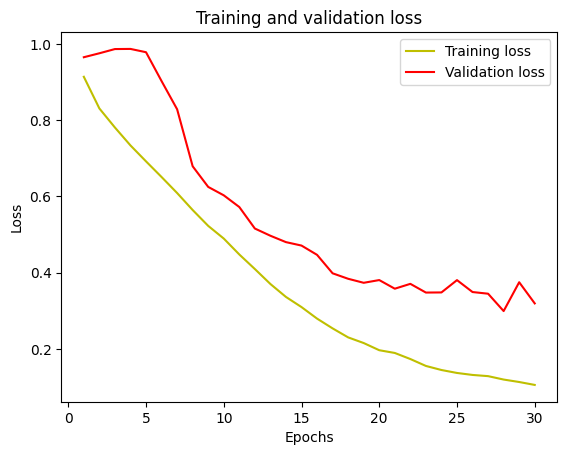

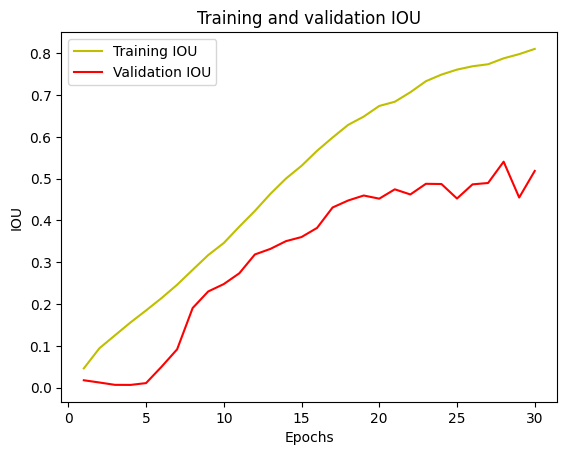

In [22]:
from matplotlib import pyplot as plt

loss = model_hist.history['loss']
val_loss = model_hist.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss') 
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = model_hist.history['iou']
val_acc = model_hist.history['val_iou']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

# Testing

In [23]:
create_dir('results')

In [24]:
# from tensorflow.keras.utils import CustomObjectScope

# with CustomObjectScope({"iou": iou, "dice_coef": dice_coef, "dice_loss": dice_loss}):
#     model = tf.keras.models.load_model(os.path.join("files", "model.h5"))

In [25]:
def save_results(image, mask, y_pred, save_image_path):
    mask = np.expand_dims(mask, axis=-1)
    mask = np.concatenate([mask, mask, mask], axis=-1)

    y_pred = np.expand_dims(y_pred, axis=-1)
    y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1)
    y_pred = y_pred * 255

    line = np.ones((Height, 10, 3)) * 255

    cat_images = np.concatenate([image, line, mask, line, y_pred], axis=1)
    cv2.imwrite(save_image_path, cat_images)

In [26]:
from sklearn.metrics import f1_score, jaccard_score, precision_score, recall_score

SCORE = []
for x, y in zip(X_test, y_test):
    """ Extracting the name """
    name = x.split("/")[-1]

    """ Reading the image """
    image = cv2.imread(x, cv2.IMREAD_COLOR) ## [H, w, 3]
    image = cv2.resize(image, (Width, Height)) ## [H, w, 3]
    x = image/255.0                         ## [H, w, 3]
    x = np.expand_dims(x, axis=0)           ## [1, H, w, 3]

    """ Reading the mask """
    mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (Width, Height))

    """ Prediction """
    y_pred = model.predict(x, verbose=0)[0]
    y_pred = np.squeeze(y_pred, axis=-1)
    y_pred = y_pred >= 0.5
    y_pred = y_pred.astype(np.int32)

    """ Saving the prediction """
    save_image_path = os.path.join("results", name)
    save_results(image, mask, y_pred, save_image_path)

    """ Flatten the array """
    mask = mask/255.0
    mask = (mask > 0.5).astype(np.int32).flatten()
    y_pred = y_pred.flatten()

    """ Calculating the metrics values """
    f1_value = f1_score(mask, y_pred, labels=[0, 1], average="binary")
    jac_value = jaccard_score(mask, y_pred, labels=[0, 1], average="binary")
    recall_value = recall_score(mask, y_pred, labels=[0, 1], average="binary", zero_division=0)
    precision_value = precision_score(mask, y_pred, labels=[0, 1], average="binary", zero_division=0)
    iou_value = iou(mask, y_pred)
    SCORE.append([name, f1_value, jac_value, recall_value, precision_value, iou_value])

In [27]:
import pandas as pd

score = [s[1:]for s in SCORE]
score = np.mean(score, axis=0)
print(f"F1: {score[0]:0.5f}")
print(f"IoU: {score[1]:0.5f}")
print(f"Recall: {score[2]:0.5f}")
print(f"Precision: {score[3]:0.5f}")
print(f"IoU: {score[4]:0.5f}")

df = pd.DataFrame(SCORE, columns=["Image", "F1", "IoU", "Recall", "Precision", "IoU"])
df.to_csv("files/score.csv")

F1: 0.65794
IoU: 0.56898
Recall: 0.61610
Precision: 0.78109
IoU: 0.56898
